<a href="https://colab.research.google.com/github/TrifanLucian/Performance-Analysis-of-Deep-Learning-Algorithms/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import concatenate

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
  # Input:
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
def cnn_googlenet():
  # input layer
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='valid', activation='relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

  # 1st Inception block
  X = Inception_block(X, f1=64, f2_conv1=96, f2_conv3=128, f3_conv1=16, f3_conv5=32, f4=32)

  # 2nd Inception block
  X = Inception_block(X, f1=128, f2_conv1=128, f2_conv3=192, f3_conv1=32, f3_conv5=96, f4=64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1=192, f2_conv1=96, f2_conv3=208, f3_conv1=16, f3_conv5=48, f4=64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size=(5, 5), strides=3)(X)
  X1 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation='relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(2, activation='softmax')(X1)

  # 4th Inception block
  X = Inception_block(X, f1=160, f2_conv1=112, f2_conv3=224, f3_conv1=24, f3_conv5=64, f4=64)

  # 5th Inception block
  X = Inception_block(X, f1=128, f2_conv1=128, f2_conv3=256, f3_conv1=24, f3_conv5=64, f4=64)

  # 6th Inception block
  X = Inception_block(X, f1=112, f2_conv1=144, f2_conv3=288, f3_conv1=32, f3_conv5=64, f4=64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size=(5, 5), strides=3)(X)
  X2 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation='relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(2, activation='softmax')(X2)

  # 7th Inception block
  X = Inception_block(X, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32,
                      f3_conv5=128, f4=128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

  # 8th Inception block
  X = Inception_block(X, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4=128)

  # 9th Inception block
  X = Inception_block(X, f1=384, f2_conv1=192, f2_conv3=384, f3_conv1=48, f3_conv5=128, f4=128)

  # Global Average pooling layer
  X = GlobalAveragePooling2D(name='GAPL')(X)

  # Dropoutlayer
  X = Dropout(0.4)(X)

  # output layer
  X = Dense(2, activation='softmax')(X)

  # model
  new_model = Model(input_layer, [X, X1, X2], name='cnn_googlenet')
  #new_model = Model(input_layer, X, name='cnn_googlenet')

  return compile_model(new_model)

In [ ]:
def dnn_model():
  new_model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    # layers.InputLayer((img_height, img_width, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
  ], name='dnn_model')
  return compile_model(new_model)

In [ ]:
def cnn_model():
  new_model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    # layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
  ], name='cnn_model')
  return compile_model(new_model)

In [ ]:
def cnn_alexnet():
  new_model = Sequential()

  # Stratul 1: Convolutional, Batch Normalization, Max Pooling
  new_model.add(layers.Conv2D(filters=96, kernel_size=(11, 11),
                          strides=(4, 4), activation="relu",
                          input_shape=(img_height, img_width, 3)))
  new_model.add(layers.BatchNormalization())
  new_model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

  # Stratul 2: Convolutional, Batch Normalization, Max Pooling
  new_model.add(layers.Conv2D(filters=256, kernel_size=(5, 5),
                          strides=(1, 1), activation="relu",
                          padding="same"))
  new_model.add(layers.BatchNormalization())
  new_model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

  # Stratul 3: Convolutional (dublu), Batch Normalization
  new_model.add(layers.Conv2D(filters=384, kernel_size=(3, 3),
                          strides=(1, 1), activation="relu",
                          padding="same"))
  new_model.add(layers.BatchNormalization())
  new_model.add(layers.Conv2D(filters=384, kernel_size=(3, 3),
                          strides=(1, 1), activation="relu",
                          padding="same"))
  new_model.add(layers.BatchNormalization())

  # Stratul 4: Convolutional (triplu), Batch Normalization, Max Pooling
  new_model.add(layers.Conv2D(filters=256, kernel_size=(3, 3),
                          strides=(1, 1), activation="relu",
                          padding="same"))
  new_model.add(layers.BatchNormalization())
  new_model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

  # Stratul 5: Complet Conectat (FC), Dropout
  new_model.add(layers.Flatten())
  new_model.add(layers.Dense(4096, activation="relu"))
  new_model.add(layers.Dropout(0.5))

  # Stratul de ieșire: Complet Conectat (FC) cu 10 clase de ieșire (presupunând 2 clase)
  new_model.add(layers.Dense(num_classes, activation="softmax"))

  new_model._name = 'cnn_alexnet'

  return compile_model(new_model)

In [ ]:
def compile_model(new_model):
  new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  print(new_model.summary())
  return new_model

In [ ]:
dataset_name = 'mere-portocale'
model_name = 'cnn_alexnet'
test_dir = f"/content/drive/MyDrive/Disertatie/{dataset_name}/valid"
data_dir = f"/content/drive/MyDrive/Disertatie/{dataset_name}/train"

params_dict = {
    'cnn_model': {'epochs': 20, 'img_height': 80, 'img_width': 80, 'batch_size': 20, 'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss' : 'loss', 'val_loss':'val_loss' },
    'cnn_googlenet': {'epochs': 5, 'img_height': 224, 'img_width': 224, 'batch_size': 20, 'acc': 'dense_4_accuracy', 'val_acc': 'val_dense_4_accuracy', 'loss' : 'dense_4_loss', 'val_loss': 'val_dense_4_loss'},
    'dnn_model': {'epochs': 20, 'img_height': 80, 'img_width': 80, 'batch_size': 20, 'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss' : 'loss', 'val_loss':'val_loss'},
    'cnn_alexnet': {'epochs': 10, 'img_height': 227, 'img_width': 227, 'batch_size': 20, 'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss' : 'loss', 'val_loss':'val_loss'}
}

model_params = params_dict[model_name]

epochs = model_params['epochs']
img_height = model_params['img_height']
img_width = model_params['img_width']
batch_size = model_params['batch_size']

acc = model_params['acc']
val_acc = model_params['val_acc']
loss = model_params['loss']
val_loss = model_params['val_loss']

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2014 files belonging to 2 classes.
Using 1612 files for training.
Found 2014 files belonging to 2 classes.
Using 402 files for validation.
Found 514 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
print(len(train_ds))
print(len(test_ds))

['mere', 'portocale']
81
26


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 227, 227, 3)
(20,)


In [ ]:
labels_batch

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0],
      dtype=int32)>

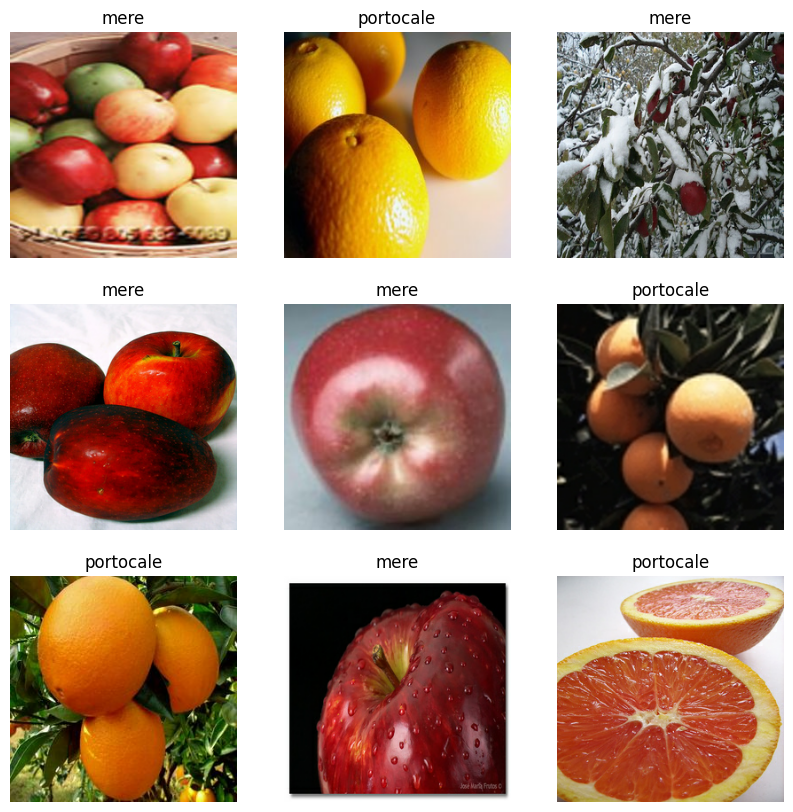

In [ ]:
import matplotlib.pyplot as plt
import time
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
   # t0 = time.clock()
 #   print (time.clock() - t0, "seconds process time")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)

In [ ]:
model = globals()[model_name]
model = model()

Model: "cnn_alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                       

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
81/81 [==============================] - 490s 5s/step - loss: 9.6485 - accuracy: 0.7798 - val_loss: 240.9420 - val_accuracy: 0.7239
Epoch 2/10
81/81 [==============================] - 343s 4s/step - loss: 6.7216 - accuracy: 0.8213 - val_loss: 14.4589 - val_accuracy: 0.8358
Epoch 3/10
81/81 [==============================] - 338s 4s/step - loss: 3.0772 - accuracy: 0.8579 - val_loss: 5.7320 - val_accuracy: 0.8433
Epoch 4/10
81/81 [==============================] - 346s 4s/step - loss: 1.8374 - accuracy: 0.8790 - val_loss: 0.9585 - val_accuracy: 0.9254
Epoch 5/10
81/81 [==============================] - 335s 4s/step - loss: 1.2628 - accuracy: 0.8753 - val_loss: 3.1195 - val_accuracy: 0.8408
Epoch 6/10
81/81 [==============================] - 344s 4s/step - loss: 0.8786 - accuracy: 0.8896 - val_loss: 0.4437 - val_accuracy: 0.8831
Epoch 7/10
81/81 [==============================] - 338s 4s/step - loss: 0.7128 - accuracy: 0.8964 - val_loss: 0.4771 - val_accuracy: 0.9129
Epoch 8/10

In [ ]:
test_images = []
test_labels = []
for image, label in test_ds.take(-1):
  test_images.extend(image)
  test_labels.extend(label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(test_images.shape)
print(test_labels.shape)

(514, 227, 227, 3)
(514,)


In [ ]:
model_evaluate = model.evaluate(test_images,  test_labels, verbose=2)

model_evaluate

17/17 - 25s - loss: 0.4045 - accuracy: 0.8677 - 25s/epoch - 1s/step


[0.4045126736164093, 0.8677042722702026]

In [ ]:
predictions = model.predict(test_images)
if model_name == 'cnn_googlenet':
  predicted_labels = np.argmax(predictions[0], axis=1)
else:
  predicted_labels = np.argmax(predictions, axis=1)

correct_predictions = np.sum(predicted_labels == test_labels)
total_examples = len(test_labels)
accuracy = correct_predictions / total_examples
print("Acuratețea modelului este:", accuracy)

conf_matrix = confusion_matrix(test_labels, predicted_labels)
print('matricea de confuzie:')
print(conf_matrix)

17/17 [==============================] - 23s 1s/step
Acuratețea modelului este: 0.867704280155642
matricea de confuzie:
[[202  64]
 [  4 244]]


In [ ]:
accuracy

0.867704280155642

In [ ]:
predictions

array([[6.0783070e-02, 9.3921679e-01],
       [9.9999994e-01, 0.0000000e+00],
       [4.7084519e-01, 5.2915472e-01],
       ...,
       [4.1381771e-08, 9.9999994e-01],
       [8.0001283e-01, 1.9998719e-01],
       [6.8653672e-25, 1.0000000e+00]], dtype=float32)

In [ ]:
# Obțineți data și ora curentă
# current_time = datetime.datetime.now()

# Formatați data și ora într-un format specific
# timestamp = current_time.strftime("%Y-%m-%d_%H-%M-%S")
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file=f"/content/drive/MyDrive/Disertatie/{model_name}_{timestamp}.png")

In [ ]:
history.history

{'loss': [9.648463249206543,
  6.721558570861816,
  3.0771987438201904,
  1.8373914957046509,
  1.2627977132797241,
  0.8786378502845764,
  0.7127756476402283,
  0.508009672164917,
  0.46119633316993713,
  0.4329507350921631],
 'accuracy': [0.7797766923904419,
  0.8213399648666382,
  0.8579404354095459,
  0.8790322542190552,
  0.8753101825714111,
  0.8895781636238098,
  0.8964020013809204,
  0.9038461446762085,
  0.9106699824333191,
  0.9205955266952515],
 'val_loss': [240.9419708251953,
  14.458930015563965,
  5.731961727142334,
  0.9585263133049011,
  3.1194581985473633,
  0.4436648190021515,
  0.4770941734313965,
  0.6072579026222229,
  0.8516004681587219,
  0.5468817353248596],
 'val_accuracy': [0.7238805890083313,
  0.8358209133148193,
  0.8432835936546326,
  0.9253731369972229,
  0.8407959938049316,
  0.8830845952033997,
  0.9129353165626526,
  0.8905472755432129,
  0.8781094551086426,
  0.8656716346740723]}

In [ ]:
keys = list(history.history.keys())
print(keys)

['loss', 'accuracy', 'val_loss', 'val_accuracy']


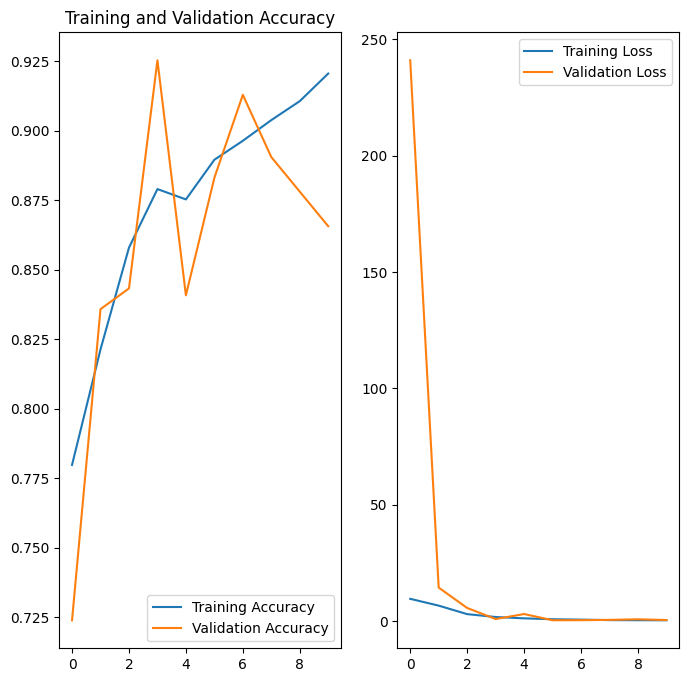

In [ ]:


# Obțineți data și ora curentă
current_time = datetime.datetime.now()

# Formatați data și ora într-un format specific
timestamp = current_time.strftime("%Y-%m-%d_%H-%M-%S")

acc = history.history[acc]
val_acc = history.history[val_acc]
loss = history.history[loss]
val_loss = history.history[val_loss]
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')

# Definiți numele fișierului folosind variabilele specifice
file_name = f"/content/drive/MyDrive/Disertatie/{dataset_name}_{model_name}_training_accuracy_epochs_{epochs}_{timestamp}.png"

# Salvați graficul într-un fișier cu numele specificat
plt.savefig(file_name)

# Afișați graficul
plt.show()

In [ ]:
# Obțineți data și ora curentă
current_time = datetime.datetime.now()

# Formatați data și ora într-un format specific
timestamp = current_time.strftime("%Y-%m-%d_%H-%M-%S")

filename = f"/content/drive/MyDrive/Disertatie/{dataset_name}_{model_name}_summary_epochs_{epochs}_{timestamp}.txt"

with open(filename, 'a') as file:
    sys.stdout = file

    # Afișați sumarul modelului
    model.summary()
    sys.stdout = sys.__stdout__
    file.write('\n\n')

    for key, value in history.history.items():
        # Scrieți numele metricii (cheia) și valorile asociate (valoarea) în fișier
        file.write(f"{key}: {value}\n")
    file.write('\n\n')

    file.write('acuratetea modelului pentru setul de testare:')
    file.write('\n')
    if model_name == 'cnn_googlenet':
      np.savetxt(file, np.array([model_evaluate[4]]), fmt='%.6f')
    else:
      np.savetxt(file, np.array([model_evaluate[1]]), fmt='%.6f')
    file.write('\n\n')  # Adăugați o linie goală între datele de acuratețe și matricea de confuzie

    file.write('Matricea de confuzie:')
    file.write('\n')


    np.savetxt(file, conf_matrix, fmt='%d')